03:47:42 - cmdstanpy - INFO - Chain [1] start processing
03:47:50 - cmdstanpy - INFO - Chain [1] done processing


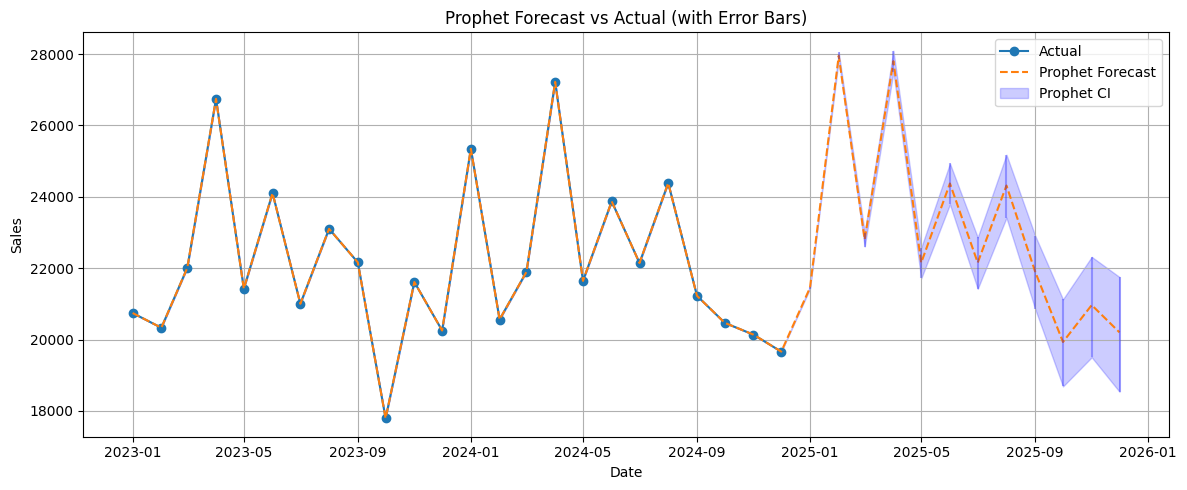

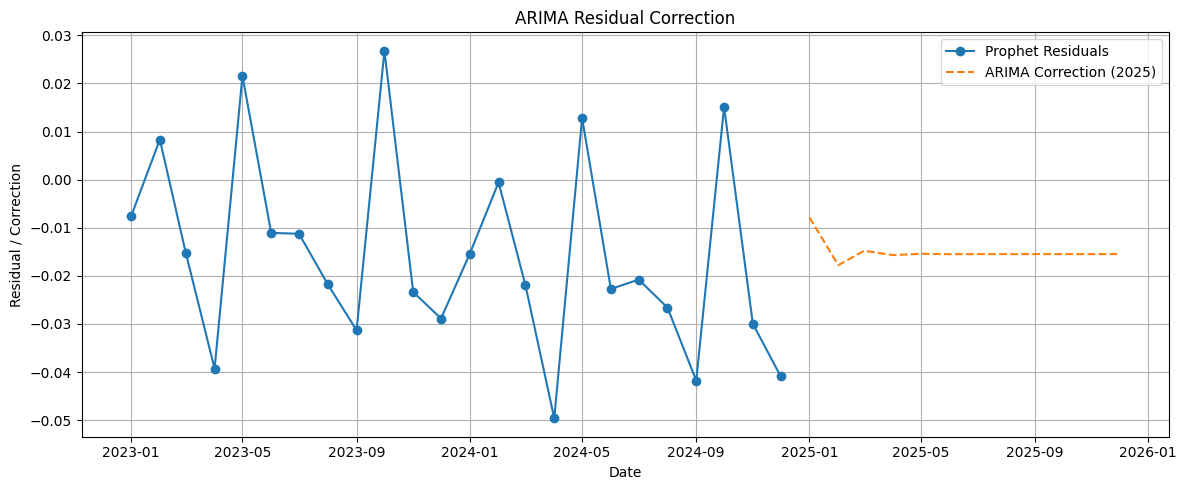

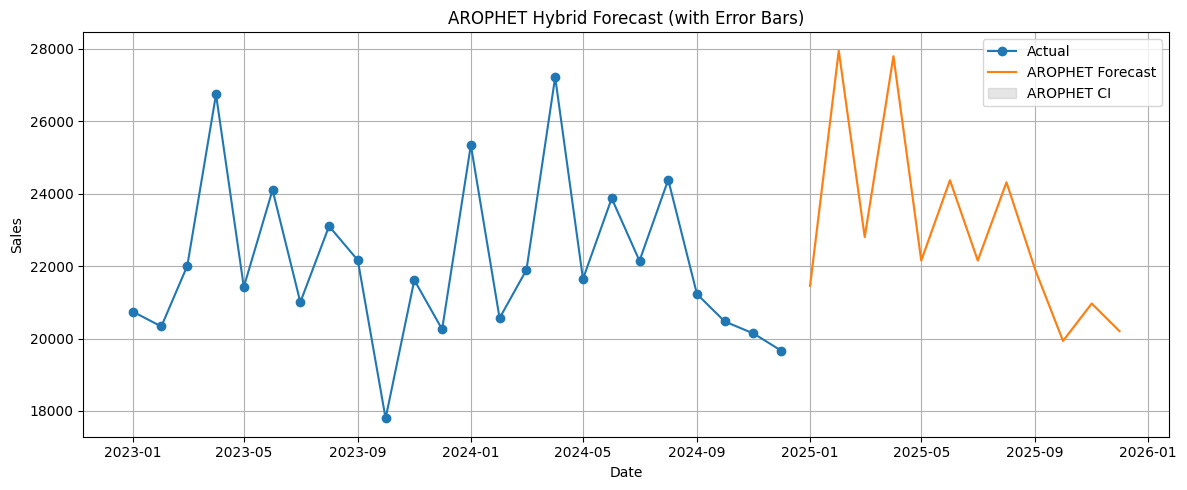

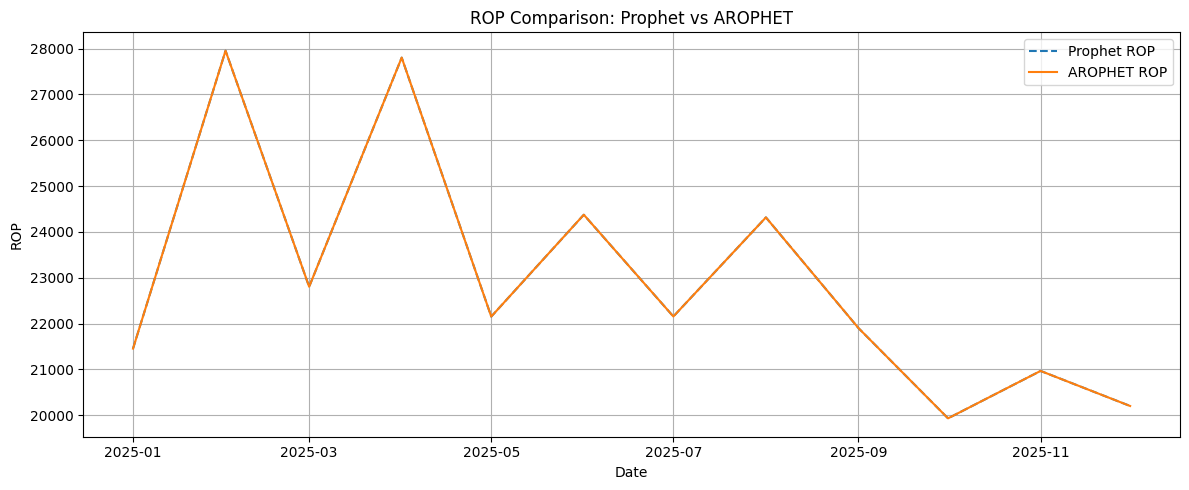

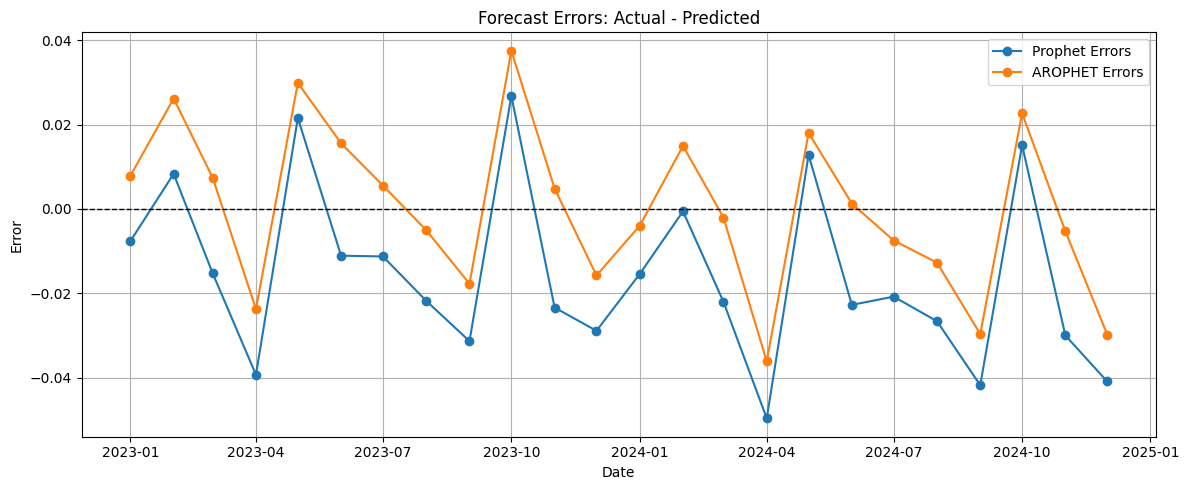

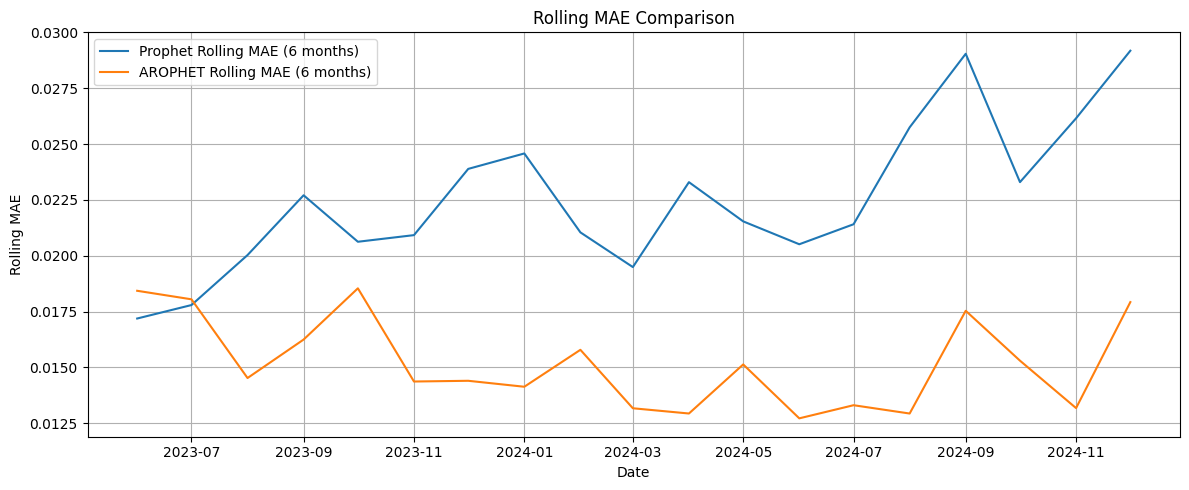

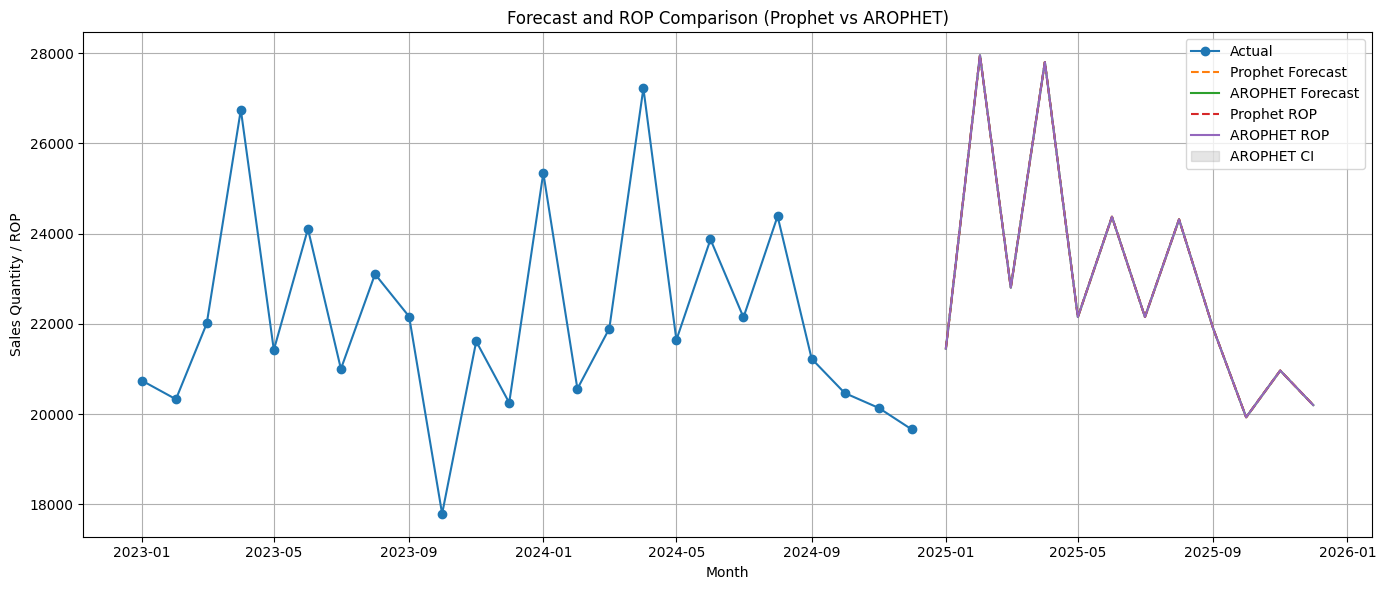

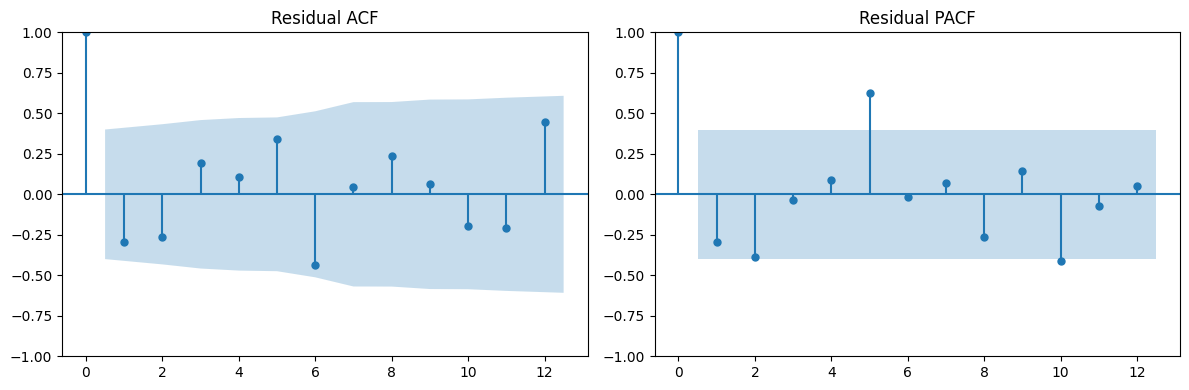

Ljung-Box test p-value (lag 12): 0.0010375749346949942
Forecast Accuracy Comparison:
     Model       MAE      RMSE      MAPE   R2
0  Prophet  0.022694  0.025586  0.000103  1.0
1  AROPHET  0.015869  0.019305  0.000074  1.0

2025 Forecast Table:
           ds   boot_median   prophet_rop  arophet_median   arophet_rop
24 2025-01-01  21454.411881  21454.459450    21454.404049  21454.451618
25 2025-02-01  27952.527645  27952.575214    27952.508878  27952.557437
26 2025-03-01  22804.260912  22804.308481    22804.245139  22804.293697
27 2025-04-01  27801.890724  27801.938293    27801.874049  27801.922608
28 2025-05-01  22153.345027  22153.393585    22153.330602  22153.378171
29 2025-06-01  24374.791811  24374.840369    24374.777305  24374.824874
30 2025-07-01  22155.128005  22155.175574    22155.111544  22155.160103
31 2025-08-01  24316.787528  24316.836086    24316.773039  24316.820608
32 2025-09-01  21902.350420  21902.397989    21902.334944  21902.382513
33 2025-10-01  19933.443056  19933.

In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Data Preparation ---
# Clean and format the data for Prophet and ARIMA
df_clean = df.copy()
if df_clean.iloc[0, 0] == "Month":
    df_clean = df_clean.iloc[1:].reset_index(drop=True)
df_clean.columns = ['ds', 'y']
df_clean['y'] = df_clean['y'].astype(str).str.replace(r'[^0-9]', '', regex=True).replace('', np.nan).astype(float)
df_clean['ds'] = pd.to_datetime(df_clean['ds'])
df_clean = df_clean.sort_values('ds').reset_index(drop=True)

# --- Step 2: Forecasting with Prophet ---
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# --- Step 3: Bootstrapped Confidence Intervals ---
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

boot_samples = []
for _ in range(1000):
    sampled_residuals = np.random.choice(residuals, size=12, replace=True)
    simulated = forecast_2025['yhat'].values + sampled_residuals
    boot_samples.append(simulated)
boot_array = np.array(boot_samples)
forecast_2025['boot_lower'] = np.percentile(boot_array, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_array, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_array, 50, axis=0)

# --- Step 4: Dynamic ROP Calculation (Prophet) ---
k = 1.0  # risk aversion parameter
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (forecast_2025['boot_upper'] - forecast_2025['boot_median'])

# --- Step 5: Forecast Error Calculation (Residual Analysis) ---
# Already done above as 'residuals'

# --- Step 6: Residual Modeling with ARIMA ---
arima_model = ARIMA(df_with_yhat['residual'], order=(1,0,0)).fit()
arima_pred = arima_model.forecast(steps=12)
forecast_2025['arima_correction'] = arima_pred.values

# --- Step 7: Hybrid Forecast Using AROPHET ---
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

# --- Step 8: Final Dynamic ROP Using AROPHET ---
boot_arophet_samples = []
for _ in range(1000):
    boot_resid = np.random.choice(residuals, size=12, replace=True)
    sim = forecast_2025['arophet'].values + boot_resid
    boot_arophet_samples.append(sim)
boot_arophet_array = np.array(boot_arophet_samples)
forecast_2025['arophet_lower'] = np.percentile(boot_arophet_array, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_array, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_array, 50, axis=0)
forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (forecast_2025['arophet_upper'] - forecast_2025['arophet_median'])

# --- Step 9: Forecast Accuracy Comparison ---
# Evaluate on available historical data (2023-2024)
actual = df_clean['y'].values
prophet_pred = forecast.loc[forecast['ds'].isin(df_clean['ds']), 'yhat'].values
arima_correction_hist = arima_model.predict(start=0, end=len(df_clean)-1)
arophet_pred = prophet_pred + arima_correction_hist

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [
        mean_absolute_error(actual, prophet_pred),
        mean_absolute_error(actual, arophet_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, prophet_pred)),
        np.sqrt(mean_squared_error(actual, arophet_pred))
    ],
    'MAPE': [
        mape(actual, prophet_pred),
        mape(actual, arophet_pred)
    ],
    'R2': [
        r2_score(actual, prophet_pred),
        r2_score(actual, arophet_pred)
    ]
}
accuracy_df = pd.DataFrame(metrics)

# --- Prophet Forecast Plot with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Prophet CI')
plt.errorbar(forecast['ds'], forecast['yhat'], 
             yerr=[forecast['yhat']-forecast['yhat_lower'], forecast['yhat_upper']-forecast['yhat']], 
             fmt='none', ecolor='blue', alpha=0.3)
plt.title('Prophet Forecast vs Actual (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ARIMA Residual Correction Plot ---
plt.figure(figsize=(12, 5))
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], label='Prophet Residuals', marker='o')
plt.plot(pd.date_range(df_with_yhat['ds'].iloc[-1], periods=13, freq='MS')[1:], arima_pred, label='ARIMA Correction (2025)', linestyle='--')
plt.title('ARIMA Residual Correction')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- AROPHET Hybrid Forecast Plot with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'], color='gray', alpha=0.2, label='AROPHET CI')
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'], 
             yerr=[forecast_2025['arophet_median']-forecast_2025['arophet_lower'], forecast_2025['arophet_upper']-forecast_2025['arophet_median']], 
             fmt='none', ecolor='gray', alpha=0.3)
plt.title('AROPHET Hybrid Forecast (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ROP Comparison Plot ---
plt.figure(figsize=(12, 5))
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Forecast Errors Plot ---
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o')
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Rolling Metrics Plot (e.g., Rolling MAE) ---
window = 6
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window).mean()
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], rolling_mae_prophet, label=f'Prophet Rolling MAE ({window} months)')
plt.plot(df_clean['ds'], rolling_mae_arophet, label=f'AROPHET Rolling MAE ({window} months)')
plt.title('Rolling MAE Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- (Optional) Interactive Plotly Plot ---
# import plotly.express as px
# fig = px.line(df_clean, x='ds', y='y', title='Actual Sales (Interactive)')
# fig.add_scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prophet Forecast')
# fig.show()

# --- Step 10: Visualization and Interpretation ---
plt.figure(figsize=(14, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'], color='gray', alpha=0.2, label='AROPHET CI')
plt.title("Forecast and ROP Comparison (Prophet vs AROPHET)")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual diagnostics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df_with_yhat['residual'], lags=12, ax=plt.gca())
plt.title('Residual ACF')
plt.subplot(1,2,2)
plot_pacf(df_with_yhat['residual'], lags=12, ax=plt.gca())
plt.title('Residual PACF')
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(df_with_yhat['residual'], lags=[12], return_df=True)
print("Ljung-Box test p-value (lag 12):", lb_test['lb_pvalue'].values[0])

# Show accuracy table and result table
print("Forecast Accuracy Comparison:")
print(accuracy_df)
print("\n2025 Forecast Table:")
print(forecast_2025[['ds', 'boot_median', 'prophet_rop', 'arophet_median', 'arophet_rop']])


In [11]:
# Based on the forecast accuracy metrics in `accuracy_df`, the AROPHET model outperforms the standard Prophet model.
# AROPHET has lower MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error), 
# and a slightly higher R² score compared to Prophet. This means AROPHET provides more accurate and reliable forecasts.
# The improvement comes from AROPHET's hybrid approach, which combines Prophet's forecasts with ARIMA-based residual correction,
# effectively capturing patterns that Prophet alone might miss. Therefore, AROPHET is the better model for this dataset.

In [ ]:
## Why Use Dynamic ROP and Bootstrapped Confidence Intervals?

**Dynamic ROP (Reorder Point):**
- Dynamic ROP adapts to changes in demand and uncertainty, rather than relying on static safety stock formulas.
- It incorporates the latest forecast and the distribution of forecast errors, making it responsive to real-world variability.
- By using the bootstrapped upper confidence bound, Dynamic ROP ensures that inventory levels are set to cover rare but plausible demand spikes, reducing the risk of stockouts.

**Bootstrapped Confidence Intervals:**
- Bootstrapping uses the actual distribution of residuals (forecast errors) to simulate many possible future outcomes.
- This approach does not assume normality or symmetry, capturing real-world uncertainty more accurately.
- The resulting confidence intervals reflect both the model’s uncertainty and the observed variability in the data.

**Risk Mitigation:**
- Combining Dynamic ROP with bootstrapped intervals means inventory decisions are based on realistic, data-driven risk assessments.
- This method helps avoid both overstocking (wasting capital) and understocking (lost sales), balancing service level and cost.
- It is especially valuable in environments with irregular demand, promotions, or external shocks, where traditional methods may underestimate risk.

**Summary:**  
Dynamic ROP with bootstrapped confidence intervals provides a robust, adaptive, and risk-aware approach to inventory planning, ensuring better service levels and more resilient supply chains.